## Disaster Detector

Practicing deep learning for NLP by creating a text classificaiton model to predict whether a social media post is about a real disaster or not (a [Kaggle "Getting Started" competition](https://www.kaggle.com/competitions/nlp-getting-started/overview)).

### Data Exploration

Being curious and inspecting everything closely, creating exploratory visualizations.  Based on what is found, adjust data processing and feature engineering accordingly.

Observations:
  - Text is all in English.
  - Keyword is only missing <1% of the time, but it's not something that would be there in the real world... excluding from predictive model because of this, but still exploring for intuitive insights.
  - Location is missing about 1/3rd of the time. Excluding from model to focus purely on text.
  - Tweets about disasters tend to be longer
  - Some of the more colorful language in keywords are much less likely to be real disasters (e.g. hellfire, armageddon, body bags)
  - Location is not standardized.  Lots of variations of the same thing that have fairly significant differences in rates of being a real disaster (e.g. "worldwide" and "everywhere"... "United Kingdom" and "UK").

In [4]:
import numpy as np
import pandas as pd

train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

print(f'Training Set Shape = {train_df.shape}')
print(f'Test Set Shape = {test_df.shape}')

train_df

Training Set Shape = (7613, 5)
Test Set Shape = (3263, 4)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [5]:
train_missing_keyword = pd.isna(train_df['keyword'])
test_missing_keyword  = pd.isna( test_df['keyword'])
train_missing_location = pd.isna(train_df['location'])
test_missing_location  = pd.isna(test_df['location'])
train_missing_keyword_location = train_missing_keyword | train_missing_location
test_missing_keyword_location  = test_missing_keyword  | test_missing_location


print(f"""% with missing keywords:
   Training: {np.round(np.mean(train_missing_keyword)*100,2)}% (n={np.sum(train_missing_keyword)})
   Test: {np.round(np.mean(test_missing_keyword)*100,2)}% (n={np.sum(test_missing_keyword)})

% of rows with missing keywords or locations:
   Training: {np.round(np.mean(train_missing_keyword_location)*100,2)}% (n={np.sum(train_missing_keyword_location)})
   Test: {np.round(np.mean(test_missing_keyword_location)*100,2)}% (n={np.sum(test_missing_keyword_location)})

% with missing locations:
   Training: {np.round(np.mean(train_missing_location)*100,2)}% (n={np.sum(train_missing_location)})
   Test: {np.round(np.mean(test_missing_location)*100,2)}% (n={np.sum(test_missing_location)})
   """)

% with missing keywords:
   Training: 0.8% (n=61)
   Test: 0.8% (n=26)

% of rows with missing keywords or locations:
   Training: 33.27% (n=2533)
   Test: 33.86% (n=1105)

% with missing locations:
   Training: 33.27% (n=2533)
   Test: 33.86% (n=1105)
   


In [6]:
### How long are the tweets?  Any differences in those that are about real disasters vs. not?
train_df["length"] = train_df["text"].apply(len)
test_df["length"] = test_df["text"].apply(len)

print("Train Length Stats:")
print(train_df["length"].describe())

print("\nTest Length Stats:")
print(test_df["length"].describe())

train_df.groupby('target').agg({'length': ["mean", "min", "max", "median"]})

Train Length Stats:
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stats:
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


length                
              mean min  max median
target                            
0        95.706817   7  157  101.0
1       108.113421  14  151  115.0

<Axes: ylabel='keyword'>

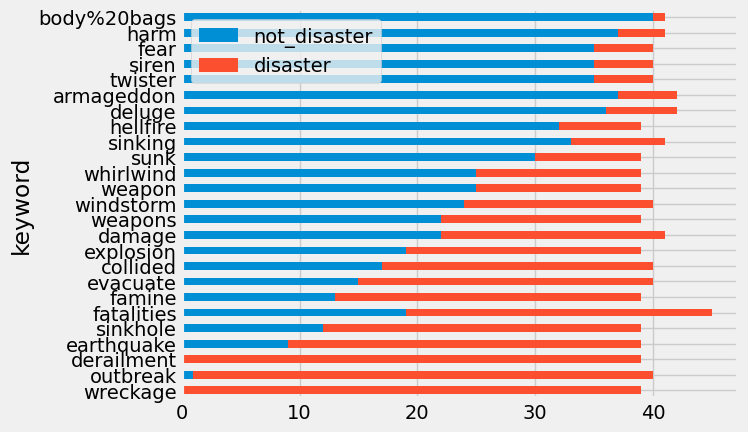

In [7]:
## Top keywords and how often they are disaster vs. not
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
top_train_keywords = train_df.keyword.value_counts().head(25)
viz_df = train_df[train_df['keyword'].isin(top_train_keywords.index)].copy()
viz_df['disaster']     = viz_df['target'].apply(lambda x: 1 if x == 1 else 0)
viz_df['not_disaster'] = viz_df['target'].apply(lambda x: 1 if x == 0 else 0)
viz_df.groupby('keyword').agg({'not_disaster': 'sum', 'disaster': 'sum'}).sort_values('disaster', ascending=False).plot.barh(stacked=True)

<Axes: ylabel='location'>

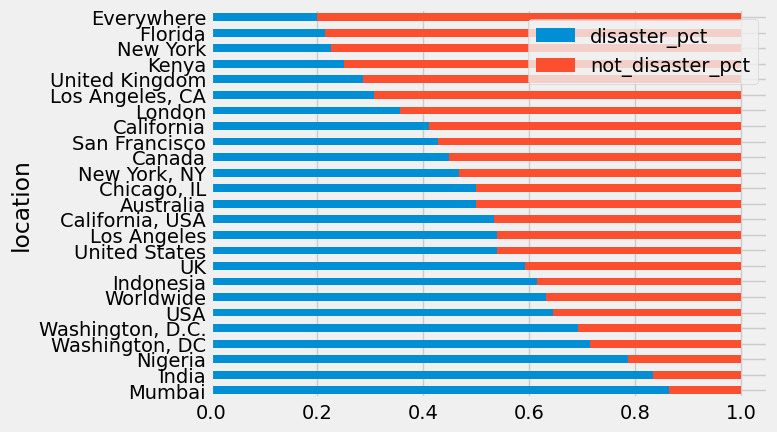

In [8]:
top_train_locations = train_df.location.value_counts().head(25)
viz_df = train_df[train_df['location'].isin(top_train_locations.index)].copy()
viz_df['disaster']     = viz_df['target'].apply(lambda x: 1 if x == 1 else 0)
viz_df['not_disaster'] = viz_df['target'].apply(lambda x: 1 if x == 0 else 0)
viz_grouped_df = viz_df.groupby('location').agg({'not_disaster': 'sum', 'disaster': 'sum'})
viz_grouped_df['disaster_pct'] = viz_grouped_df['disaster']/(viz_grouped_df['disaster']+viz_grouped_df['not_disaster'])
viz_grouped_df['not_disaster_pct'] = viz_grouped_df['not_disaster']/(viz_grouped_df['disaster']+viz_grouped_df['not_disaster'])
viz_grouped_df = viz_grouped_df.drop(columns=['disaster', 'not_disaster'])
viz_grouped_df.sort_values('disaster_pct', ascending=False).plot.barh(stacked=True)

### Preprocessing

Use a generalized approach to cleaning the text. Ideas could include removing links, correcting typos/abbreviations, and combining variations of words/acronyms.

In [13]:
import sys
import re
import string
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

sys.path.append("nlp")
import preprocess

text_vectorization = TextVectorization(
    output_mode="int",
)

In [14]:
def custom_standardization_fn(string_tensor):
    lowercase_string = tf.strings.lower(string_tensor)
    return tf.strings.regex_replace(
        lowercase_string, f"[{re.escape(string.punctuation)}]", "")

def custom_split_fn(string_tensor):
    return tf.strings.split(string_tensor)

text_vectorization = TextVectorization(
    output_mode="int",
    standardize=custom_standardization_fn,
    split=custom_split_fn,
)

In [18]:
text_vectorization.adapt(list(train_df['text']))
vocabulary = text_vectorization.get_vocabulary()

In [23]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = train_df.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE

In [28]:
from sklearn.model_selection import train_test_split

X = train_df["text"]
y = train_df["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = test_df["text"]

In [30]:
X_train = text_vectorization.call(X_train)
X_val = text_vectorization.call(X_val)
X_test = text_vectorization.call(X_test)

### Model Experimentation & Evaluation

In [20]:
from tensorflow import keras
from tensorflow.keras import layers

import model

In [21]:
vocab_size = 22699
embed_dim = 256
num_heads = 2
dense_dim = 32

inputs = keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(vocab_size, embed_dim)(inputs)
x = model.TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, None, 256)           │       5,810,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder                  │ (None, None, 256)           │         543,776 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 256)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,354,977 (24.24 MB)

 Trainable params: 6,354,977 (24.24 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("transformer_encoder.keras",
                                    save_best_only=True)
]

model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val),
          epochs=20, callbacks=callbacks)

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 48s 230ms/step - accuracy: 0.6000 - loss: 1.0156 - val_accuracy: 0.7735 - val_loss: 0.4837
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 83s 240ms/step - accuracy: 0.8313 - loss: 0.3962 - val_accuracy: 0.7728 - val_loss: 0.5097
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 44s 232ms/step - accuracy: 0.8607 - loss: 0.3233 - val_accuracy: 0.7525 - val_loss: 0.5101
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 81s 229ms/step - accuracy: 0.9027 - loss: 0.2445 - val_accuracy: 0.7741 - val_loss: 0.5415
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 83s 232ms/step - accuracy: 0.9312 - loss: 0.1778 - val_accuracy: 0.7420 - val_loss: 0.5710
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 84s 245ms/step - accuracy: 0.9574 - loss: 0.1176 - val_accuracy: 0.7912 - val_loss: 0.6005
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 42s 222ms/step - accuracy: 0.9765 - loss: 0.0716 - val_accuracy: 0.7282 - val_loss: 0.7971
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 84s 233ms/step - accuracy: 0.9835 - loss: 0

In [26]:
### TODO: Experiment with other model types (LSTM, xgboost, etc.) and architectures.

#### Submission